# Second notebook

Generates Figs. 10 to 13 of the publications. Uses the results of the first notebook (already present in the respository database)

# Load libraries

Recquires to download the DM library and to append it to the python path



In [5]:
import xarray as xr
import numpy as np
import sites
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cartopy.crs as ccrs
import cartopy
 #from mpl_toolkits.basemap import Basemap
from skimage.filters import threshold_otsu
from scipy.stats import gaussian_kde
import pandas as pd
import os
import scipy
from sklearn.linear_model import LinearRegression
#import bootstrapped.bootstrap as bs
#import bootstrapped.stats_functions as bs_stats
#import properscoring as ps
import sys

from dm_test import dm_test

%matplotlib qt5
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Fit the linear regression to correct the bias

In [6]:
size = 80
coef = np.zeros((5,6))
intercept = np.zeros((5,6))
scores = np.zeros((5,6))

for site in range(5):

    # load data
    point = xr.open_dataset('data/0/results/' + str(site) +'_point.nc')
    ssi = xr.open_dataset('data/0/results/' + str(site) +
                                              '_truth.nc').sel(time=point.time.values)

    trans = (1 - point.forecast.sel(size=size))*ssi.clear_sky.sel(lead=slice(1,6))
    bias = (trans - ssi.truth.sel(lead=slice(1,6))).dropna('time')
    forecasted = trans*(bias/bias)
    
    for lead in range(6):
        y = bias.isel(lead=lead).values[:,None]
        X = forecasted.isel(lead=lead).values[:,None]
        regression = LinearRegression()
        regression.fit(X, y)
        coef[site, lead] = regression.coef_
        intercept[site, lead] = regression.intercept_
        scores[site, lead] = regression.score(X,y)

# stock results
coefs = xr.Dataset({'coef': (['site', 'lead'], coef),
                    'intercept': (['site', 'lead'], intercept)},
                   coords={'site': np.arange(5),
                          'lead': np.arange(1,7)})

# Function to compute bootstrap scores (for satellites)

In [3]:
def compute_boostrap_ci(site, point, ssi, coefs, method, score, sat_ground):
    
    # sat or ground
    if sat_ground == 'sat':
        path_data = 'data/0/results/'
    elif sat_ground == 'ground':
        path_data = 'data/bsrn/results/'
    else:
        print('choose sat or ground...')
    
    # initialization
    lower_ci = np.zeros([6])
    mean_ci = np.zeros([6])
    upper_ci = np.zeros([6])
    
    for i_lead in range(6):
    
        # estimation
        if method == 'analog_classical':
            hat = (1 - point.forecast.sel(size=size))*ssi.clear_sky.sel(lead=slice(1,6))
        elif method == 'analog_postprocessed':
            hat = (1 - point.forecast.sel(size=size))*ssi.clear_sky.sel(lead=slice(1,6))
            hat = hat - hat*coefs.coef.sel(site=site) - coefs.intercept.sel(site=site)
        elif method == 'climatology':
            hat = (1 - point.clim)*ssi.clear_sky.sel(lead=slice(1,6))
        elif method == 'persistence':
            hat = (1 - (1 - ssi.truth.sel(lead=0)/ssi.clear_sky.sel(lead=0))) * ssi.clear_sky.sel(lead=slice(1,6))
        elif method == 'var1':
            ar1 = xr.open_dataset(path_data + str(site)+ '_AR1.nc')
            hat = (1 - ar1.forec)*ssi.clear_sky.sel(lead=slice(1,6))
            hat = hat.T
        elif method == 'PeEn':
            pen = xr.open_dataset(path_data + str(site) + '_PeEn.nc')
            hat = pen.pen
        else:
            print('choose good method...')
        hat = hat.sel(lead=i_lead+1)
        
        # truth
        true = ssi.truth.sel(lead=i_lead+1)
  
        # compute error
        error = (hat - true).values

        # remove NaN
        error=error[~np.isnan(error)]
        
        # compute score
        if score == 'MAE':
            stat = np.abs(error)
            ci = bs.bootstrap(stat, stat_func=bs_stats.mean)
        elif score == 'RMSE':
            stat = error**2
            ci = bs.bootstrap(stat, stat_func=bs_stats.mean) # ci initialization
            ci_tmp = bs.bootstrap(stat, stat_func=bs_stats.mean)
            ci.lower_bound = np.sqrt(ci_tmp.lower_bound)
            ci.value = np.sqrt(ci_tmp.value)
            ci.upper_bound = np.sqrt(ci_tmp.upper_bound)
        #elif score == 'CRPS':
        #    stat = ps.crps_ensemble(repeat(0,len(error)), error)
        #    ci = bs.bootstrap(stat, stat_func=bs_stats.mean)
        else:
            print('choose good score...')
        
        # stock results
        lower_ci[i_lead] = ci.lower_bound
        mean_ci[i_lead] = ci.value
        upper_ci[i_lead] = ci.upper_bound

    # return results
    return lower_ci, mean_ci, upper_ci

# Function to compute bootstrap scores (for ensembles)

In [4]:
def compute_boostrap_ci_ensemble(site, method, path):
        
    # initialization
    lower_ci = np.zeros([6])
    mean_ci = np.zeros([6])
    upper_ci = np.zeros([6])
    
    # load results
    if method == 'analog_classical':
        full_errors = np.load(path + str(site) + '_pdf_CRPS_full.npy')
    elif method == 'analog_postprocessed':
        full_errors = np.load(path + str(site) + '_p-analogs_CRPS_full.npy')
    elif method == 'PeEn':
        full_errors = np.load(path + str(site) + '_PeEn_CRPS_full.npy')
    elif method == 'var1':
        full_errors = np.load(path + str(site) + '_ar1_CRPS_full.npy')
    else:
        print('choose good method...')
    
    for i_lead in range(6):
        
        # compute confidence interval
        errors = full_errors[i_lead,~np.isnan(full_errors[i_lead,:])]
        ci = bs.bootstrap(errors, stat_func=bs_stats.mean)
        
        # stock results
        lower_ci[i_lead] = ci.lower_bound
        mean_ci[i_lead] = ci.value
        upper_ci[i_lead] = ci.upper_bound

    # return results
    return lower_ci, mean_ci, upper_ci

# Function to compute bootstrap scores (for ground measurements)

In [17]:
def compute_boostrap_ci_ground(site, method, path):
        
    # initialization
    lower_ci = np.zeros([6])
    mean_ci = np.zeros([6])
    upper_ci = np.zeros([6])
    
    # load results
    if method == 'analog_classical':
        full_errors = np.load(path + str(site) + '_analogs.npy').T
    elif method == 'analog_postprocessed':
        full_errors = np.load(path + str(site) + '_p-analogs.npy').T
    elif method == 'PeEn':
        full_errors = np.load(path + str(site) + '_pers.npy').T
    elif method == 'var1':
        full_errors = np.load(path + str(site) + '_ar1.npy')
    else:
        print('choose good method...')
    
    for i_lead in range(6):
        
        # select good lead time
        errors = full_errors[i_lead,~np.isnan(full_errors[i_lead,:])]
        
        # RMSE
        stat = errors**2
        
        # confidence interval
        ci = bs.bootstrap(stat, stat_func=bs_stats.mean) # ci initialization
        ci_tmp = bs.bootstrap(stat, stat_func=bs_stats.mean)
        ci.lower_bound = np.sqrt(ci_tmp.lower_bound)
        ci.value = np.sqrt(ci_tmp.value)
        ci.upper_bound = np.sqrt(ci_tmp.upper_bound)
        
        # stock results
        lower_ci[i_lead] = ci.lower_bound
        mean_ci[i_lead] = ci.value
        upper_ci[i_lead] = ci.upper_bound
        
    # return results
    return lower_ci, mean_ci, upper_ci

# Function for plotting bootstrap results

In [6]:
pylab.rcParams['figure.figsize'] = (4, 4)
def plot_bootstrap_scores(mean_ci, lower_ci, upper_ci, color, alpha_val, score, y_lim):
    
    site_names = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
    
    for site in range(5):
    
        plt.figure(site+1)
        plt.plot(range(6), mean_ci[site,:], color, linewidth=2)
        plt.fill_between(range(6), lower_ci[site,:], upper_ci[site,:],\
                         facecolor=color, alpha=alpha_val)
        plt.ylabel(score, fontsize=20)
        plt.xlabel('lead time (h)', fontsize= 20)
        xticks(range(6), ('1', '2', '3', '4', '5', '6') )
        plt.title(site_names[site], fontsize=20)
        plt.ylim(y_lim)

# Fig. 10: Mean Absolute Error

In [7]:
sat_ground = 'sat'
score = 'MAE'

# initialization
lower_ci_analog_classical = np.zeros([5,6])
mean_ci_analog_classical = np.zeros([5,6])
upper_ci_analog_classical = np.zeros([5,6])
lower_ci_analog_postprocessed = np.zeros([5,6])
mean_ci_analog_postprocessed = np.zeros([5,6])
upper_ci_analog_postprocessed = np.zeros([5,6])
lower_ci_persistence = np.zeros([5,6])
mean_ci_persistence = np.zeros([5,6])
upper_ci_persistence = np.zeros([5,6])
lower_ci_var1 = np.zeros([5,6])
mean_ci_var1 = np.zeros([5,6])
upper_ci_var1 = np.zeros([5,6])

site_names = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
for site in range(5):
    
    print(site_names[site])
    
    # load results
    point = xr.open_dataset('data/0/results/' + str(site) + '_point.nc')
    ssi = xr.open_dataset('data/0/results/' + str(site) + '_truth.nc').sel(time=point.time.values)
    
    # classical analogs
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci(site, point, ssi, coefs, 'analog_classical', score, sat_ground)
    lower_ci_analog_classical[site,:] = lower_ci_tmp
    mean_ci_analog_classical[site,:] = mean_ci_tmp
    upper_ci_analog_classical[site,:] = upper_ci_tmp
    
    # postprocessed analogs
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci(site, point, ssi, coefs, 'analog_postprocessed', score, sat_ground)
    lower_ci_analog_postprocessed[site,:] = lower_ci_tmp
    mean_ci_analog_postprocessed[site,:] = mean_ci_tmp
    upper_ci_analog_postprocessed[site,:] = upper_ci_tmp
    
    # persistence
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci(site, point, ssi, coefs, 'persistence', score, sat_ground)
    lower_ci_persistence[site,:] = lower_ci_tmp
    mean_ci_persistence[site,:] = mean_ci_tmp
    upper_ci_persistence[site,:] = upper_ci_tmp
    
    # VAR(1)
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci(site, point, ssi, coefs, 'var1', score, sat_ground)
    lower_ci_var1[site,:] = lower_ci_tmp
    mean_ci_var1[site,:] = mean_ci_tmp
    upper_ci_var1[site,:] = upper_ci_tmp

Palaiseau
Carpentras
Camborne
Payerne
Cener


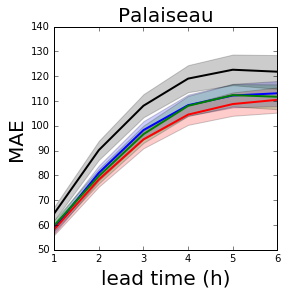

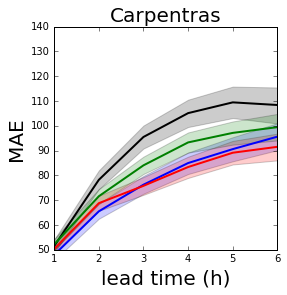

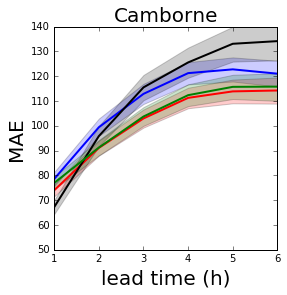

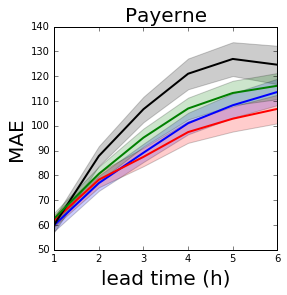

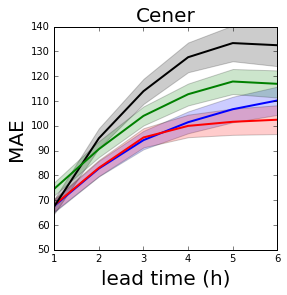

In [8]:
score = 'MAE'
alpha = 0.2
y_lim = array([50, 140])

# plot results
plot_bootstrap_scores(mean_ci_analog_classical, lower_ci_analog_classical, upper_ci_analog_classical,\
                      'blue', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_analog_postprocessed, lower_ci_analog_postprocessed, upper_ci_analog_postprocessed,\
                      'red', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_persistence, lower_ci_persistence, upper_ci_persistence,\
                      'black', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_var1, lower_ci_var1, upper_ci_var1,\
                      'green', alpha, score, y_lim)

# Fig. 11: Root Mean Square Error (satellite)

In [9]:
sat_ground = 'sat'
score = 'RMSE'

# initialization
lower_ci_analog_classical = np.zeros([5,6])
mean_ci_analog_classical = np.zeros([5,6])
upper_ci_analog_classical = np.zeros([5,6])
lower_ci_analog_postprocessed = np.zeros([5,6])
mean_ci_analog_postprocessed = np.zeros([5,6])
upper_ci_analog_postprocessed = np.zeros([5,6])
lower_ci_persistence = np.zeros([5,6])
mean_ci_persistence = np.zeros([5,6])
upper_ci_persistence = np.zeros([5,6])
lower_ci_var1 = np.zeros([5,6])
mean_ci_var1 = np.zeros([5,6])
upper_ci_var1 = np.zeros([5,6])

site_names = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
for site in range(5):
    
    print(site_names[site])
    
    # load results
    point = xr.open_dataset('data/0/results/' + str(site) + '_point.nc')
    ssi = xr.open_dataset('data/0/results/' + str(site) + '_truth.nc').sel(time=point.time.values)
    
    # classical analogs
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci(site, point, ssi, coefs, 'analog_classical', score, sat_ground)
    lower_ci_analog_classical[site,:] = lower_ci_tmp
    mean_ci_analog_classical[site,:] = mean_ci_tmp
    upper_ci_analog_classical[site,:] = upper_ci_tmp
    
    # postprocessed analogs
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci(site, point, ssi, coefs, 'analog_postprocessed', score, sat_ground)
    lower_ci_analog_postprocessed[site,:] = lower_ci_tmp
    mean_ci_analog_postprocessed[site,:] = mean_ci_tmp
    upper_ci_analog_postprocessed[site,:] = upper_ci_tmp
    
    # persistence
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci(site, point, ssi, coefs, 'persistence', score, sat_ground)
    lower_ci_persistence[site,:] = lower_ci_tmp
    mean_ci_persistence[site,:] = mean_ci_tmp
    upper_ci_persistence[site,:] = upper_ci_tmp
    
    # VAR(1)
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci(site, point, ssi, coefs, 'var1', score, sat_ground)
    lower_ci_var1[site,:] = lower_ci_tmp
    mean_ci_var1[site,:] = mean_ci_tmp
    upper_ci_var1[site,:] = upper_ci_tmp

Palaiseau
Carpentras
Camborne
Payerne
Cener


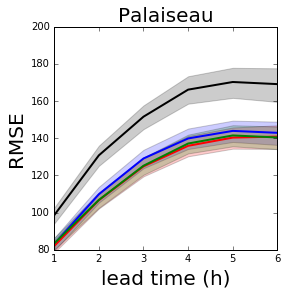

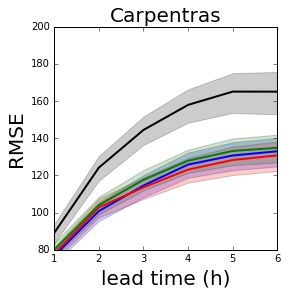

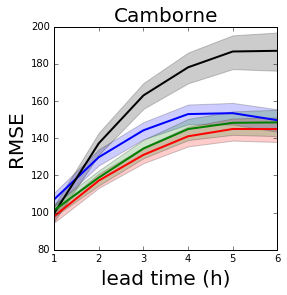

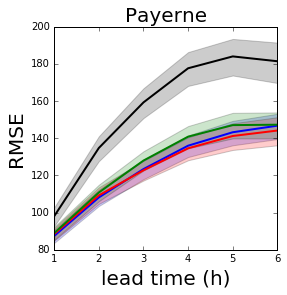

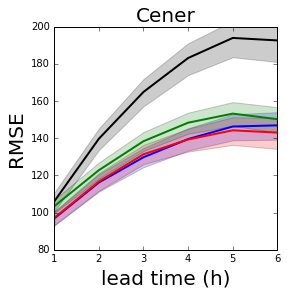

In [10]:
score = 'RMSE'
alpha = 0.2
y_lim = array([80, 200])

# plot results
plot_bootstrap_scores(mean_ci_analog_classical, lower_ci_analog_classical, upper_ci_analog_classical,\
                      'blue', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_analog_postprocessed, lower_ci_analog_postprocessed, upper_ci_analog_postprocessed,\
                      'red', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_persistence, lower_ci_persistence, upper_ci_persistence,\
                      'black', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_var1, lower_ci_var1, upper_ci_var1,\
                      'green', alpha, score, y_lim)

# Fig. 12: Continuous Ranked Probability Score

In [11]:
sat_ground = 'sat'
score = 'CRPS'
path = '/home/ptandeo/Dropbox/Documents/Codes/Python/elum_analogs/bin/PT/'

# initialization
lower_ci_analog_classical = np.zeros([5,6])
mean_ci_analog_classical = np.zeros([5,6])
upper_ci_analog_classical = np.zeros([5,6])
lower_ci_analog_postprocessed = np.zeros([5,6])
mean_ci_analog_postprocessed = np.zeros([5,6])
upper_ci_analog_postprocessed = np.zeros([5,6])
lower_ci_PeEn = np.zeros([5,6])
mean_ci_PeEn = np.zeros([5,6])
upper_ci_PeEn = np.zeros([5,6])
lower_ci_var1 = np.zeros([5,6])
mean_ci_var1 = np.zeros([5,6])
upper_ci_var1 = np.zeros([5,6])

site_names = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
for site in range(5):
    
    print(site_names[site])
    
    # classical analogs
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci_ensemble(site, 'analog_classical', path)
    lower_ci_analog_classical[site,:] = lower_ci_tmp
    mean_ci_analog_classical[site,:] = mean_ci_tmp
    upper_ci_analog_classical[site,:] = upper_ci_tmp
    
    # postprocessed analogs
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci_ensemble(site, 'analog_postprocessed', path)
    lower_ci_analog_postprocessed[site,:] = lower_ci_tmp
    mean_ci_analog_postprocessed[site,:] = mean_ci_tmp
    upper_ci_analog_postprocessed[site,:] = upper_ci_tmp
    
    # PeEn
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci_ensemble(site, 'PeEn', path)
    lower_ci_PeEn[site,:] = lower_ci_tmp
    mean_ci_PeEn[site,:] = mean_ci_tmp
    upper_ci_PeEn[site,:] = upper_ci_tmp
    
    # VAR(1)
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci_ensemble(site, 'var1', path)
    lower_ci_var1[site,:] = lower_ci_tmp
    mean_ci_var1[site,:] = mean_ci_tmp
    upper_ci_var1[site,:] = upper_ci_tmp

Palaiseau
Carpentras
Camborne
Payerne
Cener


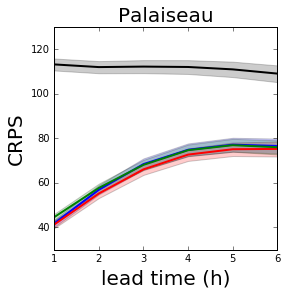

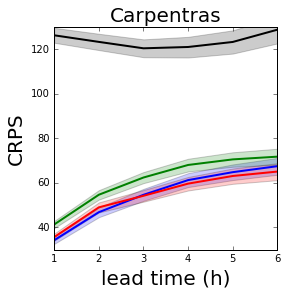

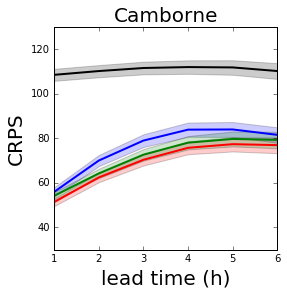

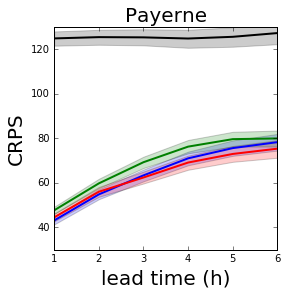

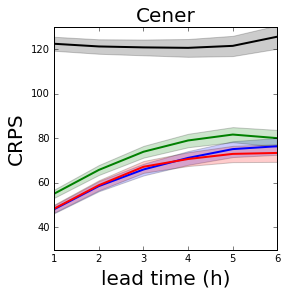

In [12]:
score = 'CRPS'
alpha = 0.2
y_lim = array([30, 130])

# plot results
plot_bootstrap_scores(mean_ci_analog_classical, lower_ci_analog_classical, upper_ci_analog_classical,\
                      'blue', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_analog_postprocessed, lower_ci_analog_postprocessed, upper_ci_analog_postprocessed,\
                      'red', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_PeEn, lower_ci_PeEn, upper_ci_PeEn,\
                      'black', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_var1, lower_ci_var1, upper_ci_var1,\
                      'green', alpha, score, y_lim)

# Fig. 13: Root Mean Square Error (ground)

In [14]:
score = 'RMSE'
path = '/home/ptandeo/Dropbox/Documents/Codes/Python/elum_analogs/bin/scores/'

# initialization
lower_ci_analog_classical = np.zeros([5,6])
mean_ci_analog_classical = np.zeros([5,6])
upper_ci_analog_classical = np.zeros([5,6])
lower_ci_analog_postprocessed = np.zeros([5,6])
mean_ci_analog_postprocessed = np.zeros([5,6])
upper_ci_analog_postprocessed = np.zeros([5,6])
lower_ci_persistence = np.zeros([5,6])
mean_ci_persistence = np.zeros([5,6])
upper_ci_persistence = np.zeros([5,6])
lower_ci_var1 = np.zeros([5,6])
mean_ci_var1 = np.zeros([5,6])
upper_ci_var1 = np.zeros([5,6])

site_names = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
for site in np.array([0, 1, 2, 4]):
    
    print(site_names[site])
    
    # classical analogs
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci_ground(site, 'analog_classical', path)
    lower_ci_analog_classical[site,:] = lower_ci_tmp
    mean_ci_analog_classical[site,:] = mean_ci_tmp
    upper_ci_analog_classical[site,:] = upper_ci_tmp
    
    # postprocessed analogs
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci_ground(site, 'analog_postprocessed', path)
    lower_ci_analog_postprocessed[site,:] = lower_ci_tmp
    mean_ci_analog_postprocessed[site,:] = mean_ci_tmp
    upper_ci_analog_postprocessed[site,:] = upper_ci_tmp
    
    # persistence
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci_ground(site, 'PeEn', path)
    lower_ci_persistence[site,:] = lower_ci_tmp
    mean_ci_persistence[site,:] = mean_ci_tmp
    upper_ci_persistence[site,:] = upper_ci_tmp
    
    # VAR(1)
    lower_ci_tmp, mean_ci_tmp, upper_ci_tmp =\
    compute_boostrap_ci_ground(site, 'var1', path)
    lower_ci_var1[site,:] = lower_ci_tmp
    mean_ci_var1[site,:] = mean_ci_tmp
    upper_ci_var1[site,:] = upper_ci_tmp

Palaiseau
Carpentras
Camborne
Cener


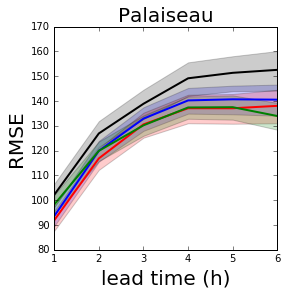

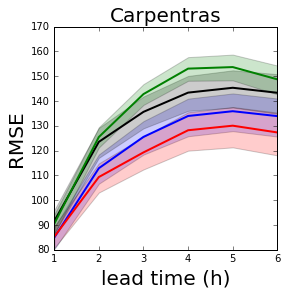

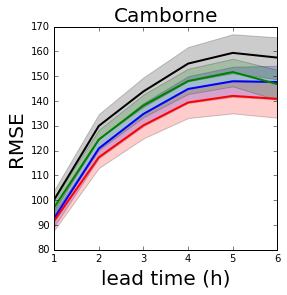

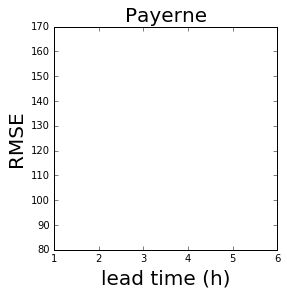

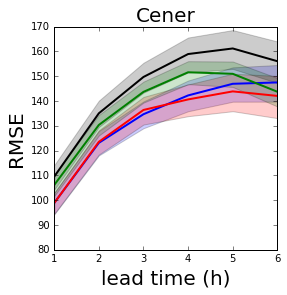

In [15]:
score = 'RMSE'
alpha = 0.2
y_lim = array([80, 170])

# plot results
plot_bootstrap_scores(mean_ci_analog_classical, lower_ci_analog_classical, upper_ci_analog_classical,\
                      'blue', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_analog_postprocessed, lower_ci_analog_postprocessed, upper_ci_analog_postprocessed,\
                      'red', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_persistence, lower_ci_persistence, upper_ci_persistence,\
                      'black', alpha, score, y_lim)
plot_bootstrap_scores(mean_ci_var1, lower_ci_var1, upper_ci_var1,\
                      'green', alpha, score, y_lim)

# Diebold-Mariano test between classical and postprocessed analogs

In [16]:
site_names = ['Palaiseau', 'Carpentras', 'Camborne', 'Payerne', 'Cener']
for site in range(5):
    
    print(site_names[site])
    
    # load results
    point = xr.open_dataset('data/0/results/' + str(site) + '_point.nc')
    ssi = xr.open_dataset('data/0/results/' + str(site) + '_truth.nc').sel(time=point.time.values)
    
    for i_lead in range(6):
    
        # estimations
        hat_analog_classical = (1 - point.forecast.sel(size=size))*ssi.clear_sky.sel(lead=slice(1,6))
        hat_analog_postprocessed = hat_analog_classical - hat_analog_classical*coefs.coef.sel(site=site) - coefs.intercept.sel(site=site)
        hat_analog_classical = np.array([hat_analog_classical[:, i_lead]])
        hat_analog_postprocessed = np.array([hat_analog_postprocessed[:, i_lead]])
        hat_analog_classical = hat_analog_classical[~np.isnan(hat_analog_classical)]
        hat_analog_postprocessed = hat_analog_postprocessed[~np.isnan(hat_analog_postprocessed)]
        
        # truth
        true = ssi.truth.sel(lead=slice(1,6))
        true = np.array([true[:, i_lead]])
        true = true[~np.isnan(true)]
        
        # Dielbold-Mariano test
        rt = dm_test(np.ravel(true), np.ravel(hat_analog_classical), np.ravel(hat_analog_postprocessed), h=i_lead+1)
        print('lead time (' + str(i_lead+1) + 'h): ')
        print(rt)

Palaiseau
lead time (1h): 
dm_return(DM=6.0620392399652694, p_value=1.528048197941304e-09)
lead time (2h): 
dm_return(DM=5.07744954071772, p_value=4.1213396701762285e-07)
lead time (3h): 
dm_return(DM=3.63533722931049, p_value=0.00028456859848758064)
lead time (4h): 
dm_return(DM=2.9226355436776492, p_value=0.0035166619049968781)
lead time (5h): 
dm_return(DM=2.653094348658235, p_value=0.0080657797971702035)
lead time (6h): 
dm_return(DM=1.9715442965786423, p_value=0.04890529650905235)
Carpentras
lead time (1h): 
dm_return(DM=-7.5719871641178083, p_value=4.9264599368257141e-14)
lead time (2h): 
dm_return(DM=-7.1106259495424533, p_value=1.5015972367279949e-12)
lead time (3h): 
dm_return(DM=4.6218264744009199, p_value=4.0308937903619299e-06)
lead time (4h): 
dm_return(DM=3.5743883142858617, p_value=0.00036046427285920486)
lead time (5h): 
dm_return(DM=2.2868335001655766, p_value=0.022350401877640376)
lead time (6h): 
dm_return(DM=2.4694155725588134, p_value=0.013680106980086522)
Camborne